In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector, FlowMatchingDistiller

In [2]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=100000, n_test=50000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")


Loading datasets...
Training set shape: (100000, 76)
Test set shape: (100000, 76)
Number of anomalies in test set: 50000.0


In [3]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")

Preprocessing data...
Done


In [4]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
flow_matching_loaded  = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size= config["batch_size"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching_loaded.load("flow_matching_model.pt")
# Predict anomaly scores
flow_scores_loaded, _ = flow_matching_loaded.predict(X_test, mode="ODE")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
)


Model loaded from flow_matching_model.pt


/home/fvaselli/Documents/PHD/fAD/fad/models/flow_matching.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vf.load_state_dict(torch.load(path))


Mean score for normal samples: 123.0608
Std score for normal samples: 2525.1509


### Now we train a distilled model based on these anomaly scores

In [5]:
config_distill_path = "../fad/models/configs/distilled_model.yaml"
with open(config_distill_path, "r") as f:
    config_distill = yaml.safe_load(f)
    
flow_matching_distiller = FlowMatchingDistiller(
    input_dim=X_train.shape[1],
    output_dim=config_distill["output_dim"],
    hidden_dim=config_distill["hidden_dim"],
    model_type=config_distill["model_type"],
    num_layers=config_distill["num_layers"],
    dropout_rate=config_distill["dropout_rate"],
    use_batch_norm=config_distill["use_batch_norm"],
    lr=config_distill["lr"],
    batch_size= config_distill["batch_size"],
    iterations=config_distill["iterations"],
    print_every=config_distill["print_every"],
    device=config_distill["device"],
)

# saturate the flow_scores at 1000
flow_scores_loaded = np.clip(flow_scores_loaded, -1000, 1000)
# standard scale the flow scores
flow_scores_loaded = preprocessor.transform(flow_scores_loaded.reshape(-1, 1), fit=True)
# Reshape the flow scores to match the input shape
flow_scores_loaded = flow_scores_loaded.reshape(-1, 1)

flow_matching_distiller.fit(X_test, flow_scores_loaded)



| iter     50 |  1.76 ms/step | loss    0.220 
| iter    100 |  1.83 ms/step | loss    0.060 
| iter    150 |  1.42 ms/step | loss    0.017 
| iter    200 |  1.19 ms/step | loss    0.036 
| iter    250 |  1.90 ms/step | loss    0.015 
| iter    300 |  1.73 ms/step | loss    0.025 
| iter    350 |  1.93 ms/step | loss    0.009 
| iter    400 |  1.70 ms/step | loss    0.019 
| iter    450 |  1.74 ms/step | loss    0.009 
| iter    500 |  1.82 ms/step | loss    0.017 
| iter    550 |  1.94 ms/step | loss    0.011 
| iter    600 |  1.72 ms/step | loss    0.015 
| iter    650 |  1.82 ms/step | loss    0.009 
| iter    700 |  1.35 ms/step | loss    0.006 
| iter    750 |  0.88 ms/step | loss    0.013 
| iter    800 |  0.90 ms/step | loss    0.010 
| iter    850 |  1.60 ms/step | loss    0.005 
| iter    900 |  1.62 ms/step | loss    0.004 
| iter    950 |  1.08 ms/step | loss    0.005 
| iter   1000 |  1.71 ms/step | loss    0.017 
| iter   1050 |  6.60 ms/step | loss    0.017 
| iter   1100

In [6]:
# predict again with the flow matching distiller and compare scores
flow_scores_distilled = flow_matching_distiller.predict(X_test)

# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores_distilled[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores_distilled[dataset.test_labels == 0]):.4f}"
)

# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores_distilled[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores_distilled[dataset.test_labels == 1]):.4f}"
)


Mean score for normal samples: -0.4272
Std score for normal samples: 0.1847
Mean score for anomalous samples: 0.4283
Std score for anomalous samples: 1.2634


(50000,)


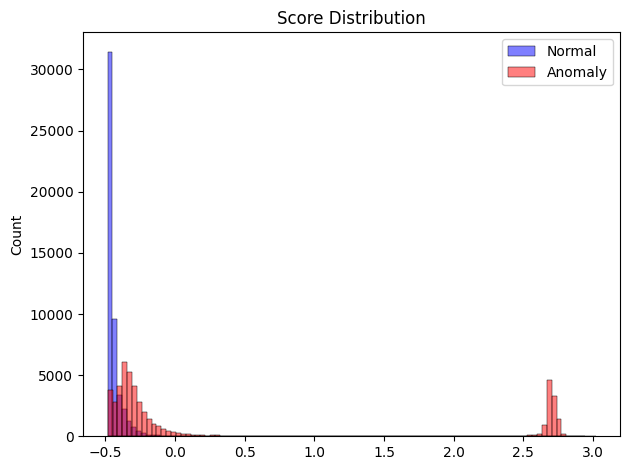

In [8]:
# Separate scores for normal and anomaly classes
normal_scores = flow_scores_distilled[dataset.test_labels == 0].flatten()
anomaly_scores = flow_scores_distilled[dataset.test_labels == 1].flatten()
print(normal_scores.shape)
# if any(anomaly_scores > 1000):
#     anomaly_scores[anomaly_scores > 1000] = 1000
#     normal_scores[normal_scores > 1000] = 1000
#     print(f"mean score for normal samples: {np.median(normal_scores)}")
#     print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
# Plot histograms
sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

plt.title(f"Score Distribution")
plt.legend()

plt.tight_layout()
plt.show()